# Setup

## Import

In [1]:
from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from obspy.geodetics import gps2dist_azimuth, locations2degrees, kilometers2degrees
from obspy import UTCDateTime
from obspy.taup import TauPyModel

from dataclasses import dataclass
from typing import List
import logging
from scipy.fft import fft, fftfreq
from multiprocessing import process
import sys

print("PyFK and other classes imported successfully!")

PyFK and other classes imported successfully!


## Modify parameters

In [2]:
from signal import SIG_DFL


@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # MODIFY: Main parameters
    source_depths = np.array([40, 50, 57, 58, 59, 61, 62, 63, 70, 80])
    receiver_distances = np.arange(800, 801, 100) 
    
    # MODIFY: Source parameters
    magnitude = 6
    strike = 90
    dip = 45
    rake = 90
    azimuth = 45

    # MODIFY: GF parameters
    npt = 2000
    dt = .1

    # MODIFY: Filtering parameters (Try [0.02-0.1] [0.05-0.2] [0.1-0.5] [0.2-1] [0.5-2][1-4])
    Sn_freqmin = 0.1 # for SnLg
    Sn_freqmax = 0.5 # for SnLg
    Lg_freqmin = 0.1 # for SnLg
    Lg_freqmax = 0.5 # for SnLg
    plot_freqmin = 0.1 # for synthetic plotting
    plot_freqmax = 0.5 # for synthetic plotting
    plot_corners = 4 # for synthetic plotting

    # Additional parameters
    vsm=4.7 # for SnLg
    vsc=3.7 # for SnLg
    moho=[70.0] # for SnLg
    sync_origintime = UTCDateTime('2021-04-28T02:21:26.196000Z') # arbitrary
    sync_longitude = -122.168861 # arbitrary
    sync_latitude = 37.428230 # arbitrary
    baz = (azimuth + 180) % 360 # auto-calculated

    # Model parameters

    # Layer 1
    layer1_thickness = 3.75
    layer1_vs = 3.7
    layer1_vp = 6.160
    layer1_rho = 2.8
    layer1_q1 = 200
    layer1_q2 = 400

    # Layer 2
    layer2_thickness = 6.25
    layer2_vs = 3.7
    layer2_vp = 6.160
    layer2_rho = 2.8
    layer2_q1 = 200
    layer2_q2 = 400

    # Layer 3
    layer3_thickness = 10
    layer3_vs = 3.7
    layer3_vp = 6.160
    layer3_rho = 2.8
    layer3_q1 = 200
    layer3_q2 = 400

    # Layer 4
    layer4_thickness = 10
    layer4_vs = 3.7
    layer4_vp = 6.160
    layer4_rho = 2.8
    layer4_q1 = 200
    layer4_q2 = 400

    # Layer 5
    layer5_thickness = 5
    layer5_vs = 3.7
    layer5_vp = 6.160
    layer5_rho = 2.8
    layer5_q1 = 200
    layer5_q2 = 400

    # Layer 6
    layer6_thickness = 5
    layer6_vs = 3.7
    layer6_vp = 6.160
    layer6_rho = 2.8
    layer6_q1 = 200
    layer6_q2 = 400
    # Depth 40 km reached

    # Layer 7
    layer7_thickness = 20
    layer7_vs = 3.7
    layer7_vp = 6.160
    layer7_rho = 2.8
    layer7_q1 = 200
    layer7_q2 = 400
    # Depth 60 reached; MOHO

    # Layer 8
    layer8_thickness = 20
    layer8_vs = 4.6
    layer8_vp = 8.290
    layer8_rho = 3.1
    layer8_q1 = 600
    layer8_q2 = 1200

    # Layer 9
    layer9_thickness = 10
    layer9_vs = 4.6
    layer9_vp = 8.290
    layer9_rho = 3.1
    layer9_q1 = 600
    layer9_q2 = 1200

    # Layer 10
    layer10_thickness = 10
    layer10_vs = 4.6
    layer10_vp = 8.290
    layer10_rho = 3.1
    layer10_q1 = 600
    layer10_q2 = 1200

    # Layer 11
    layer11_thickness = 10
    layer11_vs = 4.6
    layer11_vp = 8.290
    layer11_rho = 3.1
    layer11_q1 = 600
    layer11_q2 = 1200

    # Layer 12
    layer12_thickness = 20
    layer12_vs = 4.6
    layer12_vp = 8.290
    layer12_rho = 3.1
    layer12_q1 = 600
    layer12_q2 = 1200
    # Depth 130 km reached

    # Layer 13
    layer13_thickness = 10
    layer13_vs = 4.550
    layer13_vp = 8.290
    layer13_rho = 3
    layer13_q1 = 600
    layer13_q2 = 1200

    # Layer 14
    layer14_thickness = 10
    layer14_vs = 4.550
    layer14_vp = 8.290
    layer14_rho = 3
    layer14_q1 = 600
    layer14_q2 = 1200

    # Layer 15
    layer15_thickness = 10
    layer15_vs = 4.550
    layer15_vp = 8.290
    layer15_rho = 3
    layer15_q1 = 600
    layer15_q2 = 1200

    # Layer 16
    layer16_thickness = 10
    layer16_vs = 4.550
    layer16_vp = 8.290
    layer16_rho = 3
    layer16_q1 = 600
    layer16_q2 = 1200
    # Depth 170 km reached

    # Layer 17
    layer17_thickness = 10
    layer17_vs = 4.590
    layer17_vp = 8.200
    layer17_rho = 3.1
    layer17_q1 = 600
    layer17_q2 = 1200

    # Layer 18
    layer18_thickness = 10
    layer18_vs = 4.625
    layer18_vp = 8.270
    layer18_rho = 3.1
    layer18_q1 = 600
    layer18_q2 = 1200

    # Layer 19
    layer19_thickness = 10
    layer19_vs = 4.658
    layer19_vp = 8.340
    layer19_rho = 3.1
    layer19_q1 = 600
    layer19_q2 = 1200

    # Layer 20
    layer20_thickness = 10
    layer20_vs = 4.668
    layer20_vp = 8.400
    layer20_rho = 3.1
    layer20_q1 = 600
    layer20_q2 = 1200

    # Layer 21
    layer21_thickness = 10
    layer21_vs = 4.675
    layer21_vp = 8.420
    layer21_rho = 3.05
    layer21_q1 = 600
    layer21_q2 = 1200

    # Layer 22
    layer22_thickness = 10
    layer22_vs = 4.680
    layer22_vp = 8.430
    layer22_rho = 3.05
    layer22_q1 = 600
    layer22_q2 = 1200

    # Layer 23
    layer23_thickness = 10
    layer23_vs = 4.685
    layer23_vp = 8.440
    layer23_rho = 3.05
    layer23_q1 = 600
    layer23_q2 = 1200
    # 240 km depth reached

    def get_mechanism(self) -> List[float]:
        return [self.magnitude, self.strike, self.dip, self.rake]

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2],
            [self.layer5_thickness, self.layer5_vs, self.layer5_vp, self.layer5_rho, self.layer5_q1, self.layer5_q2],
            [self.layer6_thickness, self.layer6_vs, self.layer6_vp, self.layer6_rho, self.layer6_q1, self.layer6_q2],
            [self.layer7_thickness, self.layer7_vs, self.layer7_vp, self.layer7_rho, self.layer7_q1, self.layer7_q2],
            [self.layer8_thickness, self.layer8_vs, self.layer8_vp, self.layer8_rho, self.layer8_q1, self.layer8_q2],
            [self.layer9_thickness, self.layer9_vs, self.layer9_vp, self.layer9_rho, self.layer9_q1, self.layer9_q2],
            [self.layer10_thickness, self.layer10_vs, self.layer10_vp, self.layer10_rho, self.layer10_q1, self.layer10_q2],
            [self.layer11_thickness, self.layer11_vs, self.layer11_vp, self.layer11_rho, self.layer11_q1, self.layer11_q2],
            [self.layer12_thickness, self.layer12_vs, self.layer12_vp, self.layer12_rho, self.layer12_q1, self.layer12_q2],
            [self.layer13_thickness, self.layer13_vs, self.layer13_vp, self.layer13_rho, self.layer13_q1, self.layer13_q2],
            [self.layer14_thickness, self.layer14_vs, self.layer14_vp, self.layer14_rho, self.layer14_q1, self.layer14_q2],
            [self.layer15_thickness, self.layer15_vs, self.layer15_vp, self.layer15_rho, self.layer15_q1, self.layer15_q2],
            [self.layer16_thickness, self.layer16_vs, self.layer16_vp, self.layer16_rho, self.layer16_q1, self.layer16_q2],
            [self.layer17_thickness, self.layer17_vs, self.layer17_vp, self.layer17_rho, self.layer17_q1, self.layer17_q2],
            [self.layer18_thickness, self.layer18_vs, self.layer18_vp, self.layer18_rho, self.layer18_q1, self.layer18_q2], 
            [self.layer19_thickness, self.layer19_vs, self.layer19_vp, self.layer19_rho, self.layer19_q1, self.layer19_q2],
            [self.layer20_thickness, self.layer20_vs, self.layer20_vp, self.layer20_rho, self.layer20_q1, self.layer20_q2],
            [self.layer21_thickness, self.layer21_vs, self.layer21_vp, self.layer21_rho, self.layer21_q1, self.layer21_q2],
            [self.layer22_thickness, self.layer22_vs, self.layer22_vp, self.layer22_rho, self.layer22_q1, self.layer22_q2],
            [self.layer23_thickness, self.layer23_vs, self.layer23_vp, self.layer23_rho, self.layer23_q1, self.layer23_q2],
        ])

# Create configuration instance
parameters = SimulationConfig()
print("Config created successfully!")
print("Source depths: ", parameters.source_depths)
print("Receiver distances: ", parameters.receiver_distances)

Config created successfully!
Source depths:  [40 50 57 58 59 61 62 63 70 80]
Receiver distances:  [800]


## Plot models

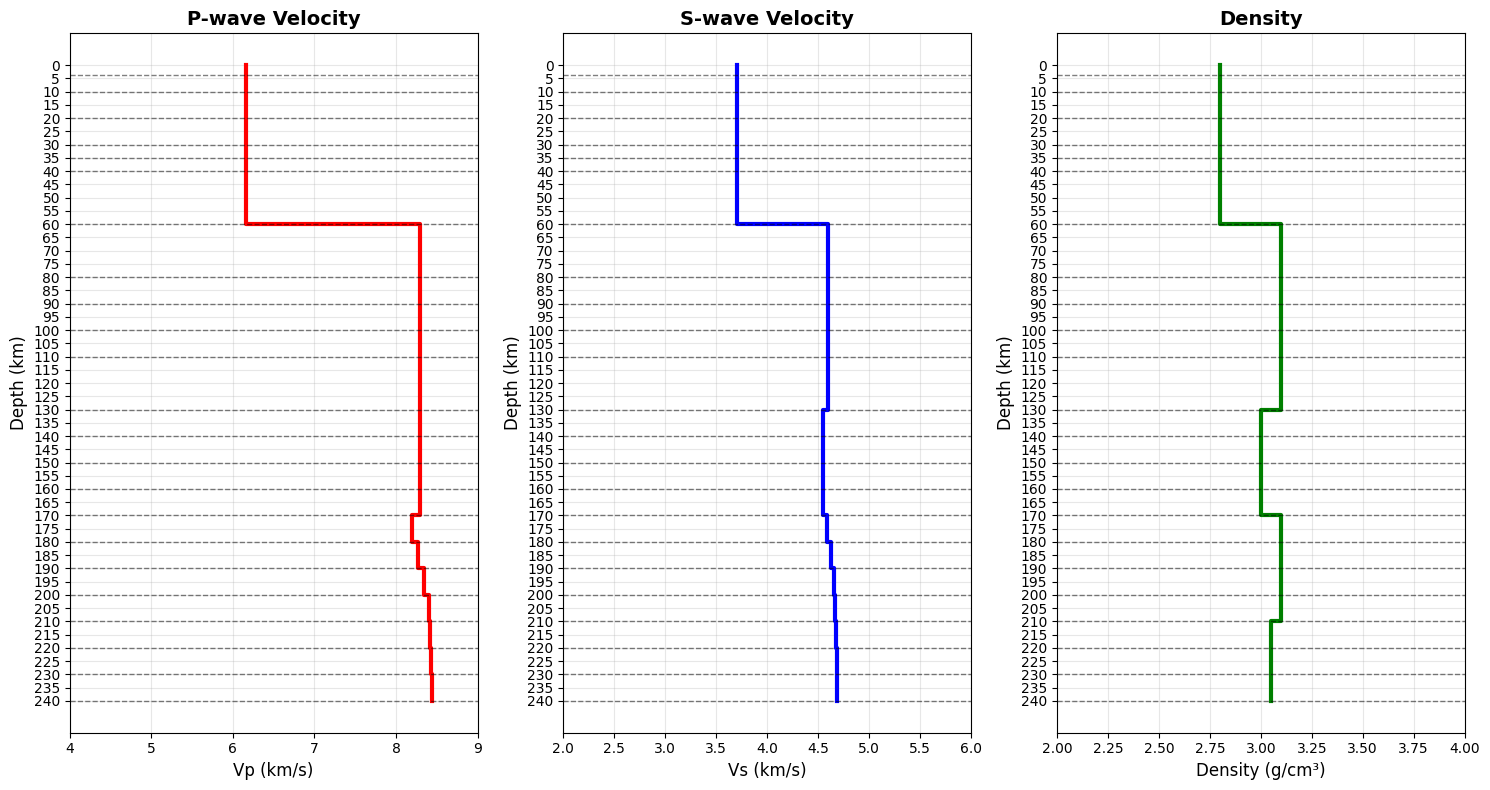

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_with_ticks(parameters, y_ticks_spacing=5):
    """
    Plot Vp, Vs, and density vs depth with more tick marks on y-axis
    
    Parameters:
    -----------
    parameters : SimulationConfig
        Your configuration object with get_model_data() method
    y_ticks_spacing : float
        Spacing between y-axis tick marks in km (default: 5 km)
    """
    
    # Get model data from your function
    model_data = parameters.get_model_data()
    
    # Create depth arrays for each layer
    depths = []
    vp_values = []
    vs_values = []
    rho_values = []
    
    current_depth = 0
    for layer in model_data:
        thickness, vs, vp, rho, q1, q2 = layer
        
        # Add interface points (top and bottom of layer)
        depths.extend([current_depth, current_depth + thickness])
        vp_values.extend([vp, vp])
        vs_values.extend([vs, vs])
        rho_values.extend([rho, rho])
        current_depth += thickness
    
    # Create the plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
    
    # Plot Vp
    ax1.plot(vp_values, depths, 'r-', linewidth=3, label='Vp')
    ax1.set_xlabel('Vp (km/s)', fontsize=12)
    ax1.set_ylabel('Depth (km)', fontsize=12)
    ax1.set_title('P-wave Velocity', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()  # Depth increases downward
    ax1.set_xlim(4, 9)
    
    # Set y-axis ticks with more resolution
    max_depth = max(depths)
    y_ticks = np.arange(0, max_depth + y_ticks_spacing, y_ticks_spacing)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels([f'{tick:.0f}' for tick in y_ticks])
    
    # Plot Vs
    ax2.plot(vs_values, depths, 'b-', linewidth=3, label='Vs')
    ax2.set_xlabel('Vs (km/s)', fontsize=12)
    ax2.set_ylabel('Depth (km)', fontsize=12)
    ax2.set_title('S-wave Velocity', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.invert_yaxis()
    ax2.set_xlim(2, 6)
    
    # Set y-axis ticks with more resolution
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels([f'{tick:.0f}' for tick in y_ticks])
    
    # Plot Density
    ax3.plot(rho_values, depths, 'g-', linewidth=3, label='Density')
    ax3.set_xlabel('Density (g/cm³)', fontsize=12)
    ax3.set_ylabel('Depth (km)', fontsize=12)
    ax3.set_title('Density', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.invert_yaxis()
    ax3.set_xlim(2, 4)
    
    # Set y-axis ticks with more resolution
    ax3.set_yticks(y_ticks)
    ax3.set_yticklabels([f'{tick:.0f}' for tick in y_ticks])
    
    # Add layer boundaries
    for ax in [ax1, ax2, ax3]:
        current_depth = 0
        for layer in model_data:
            thickness = layer[0]
            depth_boundary = current_depth + thickness
            ax.axhline(y=depth_boundary, color='k', linestyle='--', alpha=0.5, linewidth=1)
            current_depth += thickness
    
    plt.tight_layout()
    plt.show()

# Usage examples:
plot_model_with_ticks(parameters, y_ticks_spacing=5)   # Every 5 km
# plot_velocity_model_with_ticks(parameters, y_ticks_spacing=2)   # Every 2 km
# plot_velocity_model_with_ticks(parameters, y_ticks_spacing=1)   # Every 1 km

## Define models

In [4]:
# Create seismic model
model_data = parameters.get_model_data()
model = SeisModel(model=model_data, flattening = True)

# Create sources array
def setup_source(parameters, i):
    """Setup a source at a given depth (i)"""
    # Create source model
    source = SourceModel(
        sdep=parameters.source_depths[i],
        srcType="dc",
        source_mechanism=parameters.get_mechanism()
    )
    print(f"Source {i}:", source)
    return source
print("Creating sources array...")
sources = []
for i in range(len(parameters.source_depths)):
    source = setup_source(parameters, i)
    sources.append(source)

# Create configs array
def setup_config(model, source, parameters):
    """Setup configuration object for a given source; with error handling"""
    try:
        
        config_obj = Config(
            model=model,
            source=source,
            npt=parameters.npt,
            dt=parameters.dt,
            receiver_distance=np.array(parameters.receiver_distances)
        )
        print(f"Config {i}:", config_obj)
        return config_obj

    except Exception as e:
        logging.error(f"Error setting up configuration: {e}")
        raise
print("Creating configs array...")
configs = []
for i in range(len(sources)):
    config_obj= setup_config(model, sources[i], parameters)
    configs.append(config_obj)

Creating sources array...
Source 0: SourceModel(sdep=40, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 1: SourceModel(sdep=50, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 2: SourceModel(sdep=57, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 3: SourceModel(sdep=58, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 4: SourceModel(sdep=59, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 5: SourceModel(sdep=61, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 6: SourceModel(sdep=62, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 7: SourceModel(sdep=63, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 8: SourceModel(sdep=70, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 9: SourceModel(sdep=80, srcType=dc, source_mechanism=[ 6 90 45 90])
Creating configs array...
Config 0: Config(model=SeisModel(layers=24, flattening=True), source=SourceModel(sdep=40.12609705751567, srcType=dc, source_mechanism=[ 6 90 45 90]), receiver_distance=[800.], taper=0.3, filter=(0, 

# Calculate Green's functions

In [5]:
# gfs = []

# for i in range(len(configs)):
#     config = configs[i]
#     gf = calculate_gf(config)
#     gfs.append(gf)
#     print('Calculated Green\'s function for source depth: ' + str(int(parameters.source_depths[i])).zfill(2) + 'km')

# print("----------------Structure of gfs----------------")
# print("gfs is an array; length equal to # of depths: \n", (gfs))
# print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
# print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

## Read/save Green's functions

In [6]:
import os
from glob import glob
import obspy

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs) # Number of depths
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i] # Streams for given depth, one for each receiver distance
        for j in range(len(gf_w)): # Loop over stream for given depth and receiver distance
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

In [7]:
# Folder Bulk_gfs, subfolder 01, file grn_001_06 indicates 2nd depth (01, 0 index), 2nd receiver (001, 0 index), 6th trace (06, 1 index)
# saveGF('Song_gfs', gfs)
gfs = readGF('Song_gfs')

print("----------------Structure of gfs----------------")
print("gfs is an array; length equal to # of depths: \n", (gfs))
print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x14f0078b0>], [<obspy.core.stream.Stream object at 0x14f0f78e0>], [<obspy.core.stream.Stream object at 0x14f0fd700>], [<obspy.core.stream.Stream object at 0x14f101b50>], [<obspy.core.stream.Stream object at 0x14f1086d0>], [<obspy.core.stream.Stream object at 0x14f10b8e0>], [<obspy.core.stream.Stream object at 0x14f10dcd0>], [<obspy.core.stream.Stream object at 0x14f111e50>], [<obspy.core.stream.Stream object at 0x14f117a60>], [<obspy.core.stream.Stream object at 0x14f11c460>]]
gfs[0] are the streams for 1st depth; length equal to # of receivers: 
gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: 
 9 Trace(s) in Stream:
... | 1970-01-01T00:01:39.191360Z - 1970-01-01T00:04:59.091360Z | 10.0 Hz, 2000 samples
... | 1970-01-01T00:01:39.191360Z - 1970-01-01T00:04:59.091360Z | 10.0 Hz, 2000 samples
... | 1970-01-01T00:01:39.191360Z 

# Generate STF

Frequency sigma: 2.0 Hz
Time sigma: 0.080 seconds
Duration: 3.000 seconds
Sampling rate: 10 Hz
Number of points: 31


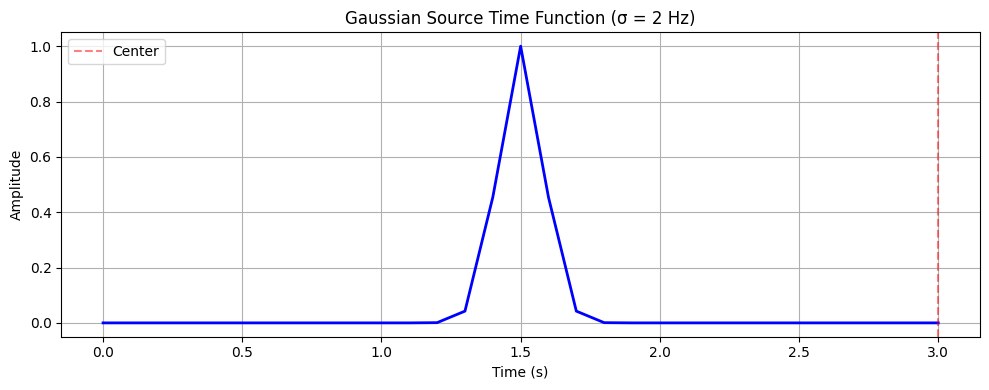

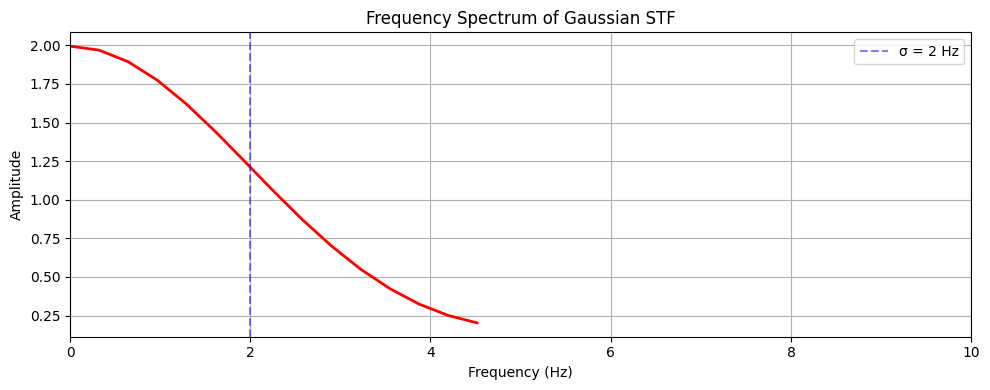

In [8]:
# # ------ Triangular
# source_time_function = generate_source_time_function(dura=dura, rise=rise, delta=delta) # SET THESE PARAMETERS
# print("Triangular source time function generated.")

import numpy as np
from obspy import Trace
import matplotlib.pyplot as plt

def generate_gaussian_stf(sigma_freq=2.0, delta=0.05, duration=3.0):
    """
    Generate a Gaussian source time function with standard deviation 2 Hz.
    
    Parameters:
    -----------
    sigma_freq : float = 2.0
        Standard deviation in frequency domain (Hz)
    delta : float = 0.05
        Time sampling interval (seconds)
    duration : float = 3.0
        Total duration (seconds) - appropriate for 800 km distance
    
    Returns:
    --------
    obspy.Trace
        Gaussian source time function
    """
    # Convert frequency sigma to time sigma
    sigma_time = 1.0 / (2.0 * np.pi * sigma_freq)  # ≈ 0.08 seconds
    
    # Time array
    t = np.arange(0, duration + delta, delta)
    center_time = duration / 2
    
    # Generate Gaussian in time domain
    stf = np.exp(-0.5 * ((t - center_time) / sigma_time)**2)
    
    # Normalize to maximum amplitude of 1
    stf = stf / np.max(np.abs(stf))
    
    # Create ObsPy Trace
    trace = Trace(data=stf)
    trace.stats.delta = delta
    trace.stats.starttime = 0
    
    return trace

# Generate the Gaussian STF
gaussian_stf = generate_gaussian_stf(sigma_freq=2.0, delta=0.1, duration=3.0)

# Print parameters for verification
sigma_time = 1.0 / (2.0 * np.pi * 2.0)
print(f"Frequency sigma: {2.0} Hz")
print(f"Time sigma: {sigma_time:.3f} seconds")
print(f"Duration: {gaussian_stf.stats.endtime - gaussian_stf.stats.starttime:.3f} seconds")
print(f"Sampling rate: {1/gaussian_stf.stats.delta:.0f} Hz")
print(f"Number of points: {len(gaussian_stf.data)}")

# Plot to verify it looks Gaussian
plt.figure(figsize=(10, 4))
plt.plot(gaussian_stf.times(), gaussian_stf.data, 'b-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Gaussian Source Time Function (σ = 2 Hz)')
plt.grid(True)
plt.axvline(gaussian_stf.stats.endtime - gaussian_stf.stats.starttime, color='r', linestyle='--', alpha=0.5, label='Center')
plt.legend()
plt.tight_layout()
plt.show()

# Plot frequency spectrum to verify
from scipy.fft import fft, fftfreq
freq = fftfreq(len(gaussian_stf.data), gaussian_stf.stats.delta)
spectrum = np.abs(fft(gaussian_stf.data))
spectrum = spectrum[:len(spectrum)//2]  # Only positive frequencies
freq = freq[:len(freq)//2]

plt.figure(figsize=(10, 4))
plt.plot(freq, spectrum, 'r-', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Gaussian STF')
plt.grid(True)
plt.axvline(2.0, color='b', linestyle='--', alpha=0.5, label='σ = 2 Hz')
plt.xlim(0, 10)
plt.legend()
plt.tight_layout()
plt.show()

## Plot STF with filter band

Frequencies above 10% max: 0.32 to 4.52 Hz


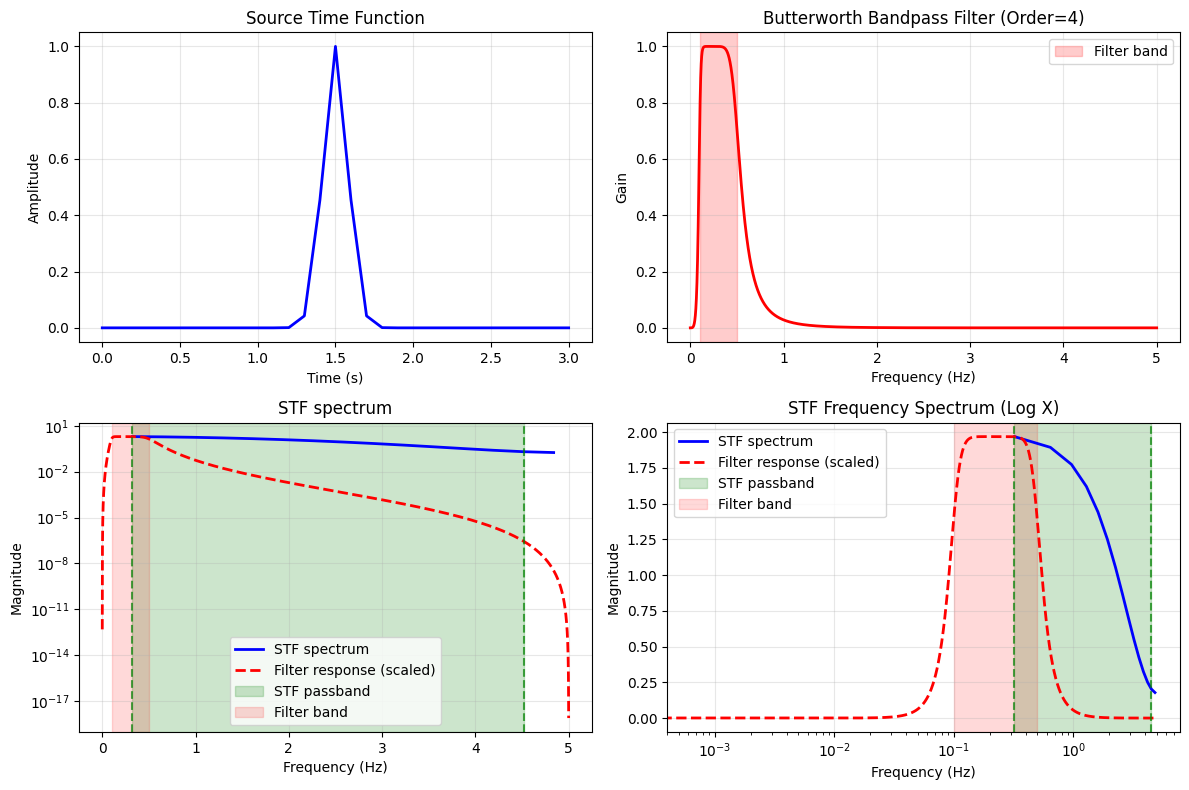

STF passband: 0.32-4.52 Hz
Filter band: 0.1-0.5 Hz


In [9]:
# Calculate frequency spectrum
n = len(gaussian_stf.data)  # Get the number of points in the STF
freq = fftfreq(n, gaussian_stf.stats.delta)  # Create frequency axis
fft_stf = fft(gaussian_stf.data)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)  # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold
if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = gaussian_stf.times()  # Use ObsPy's times() method
ax1.plot(time_stf, gaussian_stf.data, 'b-', linewidth=2)
ax1.set_title(f'Source Time Function')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from parameters)
from scipy.signal import butter, freqz
# Filter parameters
freqmin = parameters.plot_freqmin
freqmax = parameters.plot_freqmax
corners = 4
fs = 1.0 / parameters.dt  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()


# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {freqmin}-{freqmax} Hz")

# Calculate synthetics

In [10]:
sync_results = []
for i in range(len(gfs)): # loop over depths
    sync_result = calculate_sync(gfs[i], configs[i], parameters.azimuth, gaussian_stf) # calculate sync for given depth, all receivers
    sync_results.append(sync_result)
    print(f"Calculated synthetic seismograms for depth {i}: {sync_result}")

print("----------------Structure of sync_results----------------")
print("sync_results is an array; length equal to # of depths: \n", sync_results)
print("sync_results[0] are the streams for 1st depth; length equal to # of receivers: \n", sync_results[0])
print("sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: \n", sync_results[0][0]) 

for i in range(len(sync_results)):
    for j in range(len(sync_results[i])):
        selected_sync = sync_results[i][j] # stream for given depth (i) and receiver distance (j)
        # Assign channel codes to synthetic traces (Z, R, T components)
        channel_codes = ['BHZ', 'BHR', 'BHT'] 
        for k, tr in enumerate(selected_sync):
            tr.stats.channel = channel_codes[k]
        # Set synthetic trace to start at correct time (accounting for shift)
        for tr in selected_sync:
            tr.stats.starttime = parameters.sync_origintime + tr.stats.sac.b
            tr.stats.sac.o = -tr.stats.sac.b

Calculated synthetic seismograms for depth 0: [<obspy.core.stream.Stream object at 0x103a065e0>]
Calculated synthetic seismograms for depth 1: [<obspy.core.stream.Stream object at 0x14f0edf70>]
Calculated synthetic seismograms for depth 2: [<obspy.core.stream.Stream object at 0x103a379d0>]
Calculated synthetic seismograms for depth 3: [<obspy.core.stream.Stream object at 0x102b7f430>]
Calculated synthetic seismograms for depth 4: [<obspy.core.stream.Stream object at 0x103a019d0>]
Calculated synthetic seismograms for depth 5: [<obspy.core.stream.Stream object at 0x103a0ba30>]
Calculated synthetic seismograms for depth 6: [<obspy.core.stream.Stream object at 0x14ab7e790>]
Calculated synthetic seismograms for depth 7: [<obspy.core.stream.Stream object at 0x103a4f430>]
Calculated synthetic seismograms for depth 8: [<obspy.core.stream.Stream object at 0x15a971a60>]
Calculated synthetic seismograms for depth 9: [<obspy.core.stream.Stream object at 0x15a971c40>]
----------------Structure of s

# Run SnLg on synthetics

In [11]:
sys.path.append("/Users/emmanuelzheng/Downloads/Synthetics")

# --- 1. Imports ---
from SnLg.snlg_analyses import SnLg_Analyses, SnLg_OneEventStationPair
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import copy

# --- 2. Prepare synthetic waveforms ---
sync_SnLg = copy.deepcopy(sync_results)
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):
        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        selected_sync.rotate('RT->NE', back_azimuth=parameters.baz) # rotate to ZNE

# --- BEGIN CALCULATING SnLg FOR ALL WAVEFORMS AT THIS POINT ---
results = []
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):

        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        depth = parameters.source_depths[i]
        receiver_distance = parameters.receiver_distances[j]

        # --- 3. Prepare event data ---
        from collections import namedtuple
        Event = namedtuple('Event', ['event_lat', 'event_lon', 'event_dep', 'event_time', 'event_mag'])
        event = Event(
            event_lat=parameters.sync_latitude,
            event_lon=parameters.sync_longitude,
            event_dep=depth,
            event_time=parameters.sync_origintime,
            event_mag=parameters.magnitude
        )

        # --- 4. Calculate other required parameters ---
        gcarc = kilometer2degrees(receiver_distance)
        model = TauPyModel(model="iasp91")
        arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=gcarc, phase_list=['p', 'P'])
        p_arrival = event.event_time + arrivals[0].time if arrivals else None

        # --- 5. Create the SnLg_Analyses objects ---
        snlg_analyzer = SnLg_Analyses(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=parameters.vsm,
            vsc=parameters.vsc,
            moho=parameters.moho,
            sn_filt=(parameters.Sn_freqmin, parameters.Sn_freqmax),
            lg_filt=(parameters.Lg_freqmin, parameters.Lg_freqmax)
        )
        snlg_analyzer.snlg_onepair = SnLg_OneEventStationPair(
            event=event,
            station=None,
        )

        # --- 6. Run the analysis on synthetic stream ---
        snlg_analyzer.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.baz)

        # --- 7. Get the results from synthetic stream ---
        print("---------Stats for depth", depth, "and receiver distance", receiver_distance, "---------")
        print("Sn/Lg raw ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_raw)
        print("Sn/Lg corrected ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_cor)
        print("Sn window:", snlg_analyzer.snlg_onepair.sn_window)
        print("Lg window:", snlg_analyzer.snlg_onepair.lg_window)

        # --- 8. Get theoretical SnLg arrival times ---
        def snlg_arrival(d, H, g, vsm, vsc):
            '''
            d: depth
            H: Moho depth
            g: receiver distance
            vsm: velocity of s in mantle
            vsc: velocity of s in crust
            '''
            import sympy as sp
            import math
            from sympy.solvers import solve
            from sympy import Symbol
            if d > H:
                t = Symbol('t')
                tn = solve(-(g - t)/sp.sqrt((g-t)**2 + H**2)/vsc + t/sp.sqrt(t**2 + (d - H)**2) / vsm, t)
                if tn[0] > 0:
                    tn = tn[0]
                else:
                    tn = tn[1]
                    print('Warning: Solving something strange')
                tn = float(tn)
                tsn = np.sqrt((g-tn)**2 + H**2) / vsc + np.sqrt(tn**2 + (d - H)**2) / vsm
                tlg = (d - H)/vsm + np.sqrt(H**2 + g**2)/ vsc
            else:
                tsn = g / vsm + (2*H - d) * np.sqrt(vsm**2 - vsc**2) / vsm / vsc
                tlg = np.sqrt(d**2 + g**2)/vsc
            return tsn, tlg
        tsn, tlg = snlg_arrival(depth, parameters.moho[0], receiver_distance, parameters.vsm, parameters.vsc)

        # --- 9. Save the results as a tuple ---
        result_new= (depth, receiver_distance, snlg_analyzer.snlg_onepair.SnRLg_raw, snlg_analyzer.snlg_onepair.SnRLg_cor, snlg_analyzer.snlg_onepair.sn_window, snlg_analyzer.snlg_onepair.lg_window, snlg_analyzer.snlg_onepair.amp_sn, snlg_analyzer.snlg_onepair.amp_lg, tsn, tlg)
        results.append(result_new)

# # --- 10. Save the results as a pandas DataFrame ---
# results_df = pd.DataFrame(results, columns=['depth', 'receiver_distance', 'SnRLg_raw', 'SnRLg_cor', 'sn_window', 'lg_window'])
# results_df.to_csv('results.csv', index=False)

/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------Stats for depth 40 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.5747463894597664
Sn/Lg corrected ratio (ln): -2.74744027143432
Sn window: (181.12344091267727, 209.90173230207665)
Lg window: (212.88903135471193, 248.86189559146115)


/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------Stats for depth 50 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.642144119821284
Sn/Lg corrected ratio (ln): -2.8148380017958377
Sn window: (179.45680758936624, 208.23509897876562)
Lg window: (213.04081549364125, 249.01367973039046)
---------Stats for depth 57 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.6384161023289563
Sn/Lg corrected ratio (ln): -2.81110998430351
Sn window: (178.2901642630485, 207.06845565244788)
Lg window: (213.16705259582903, 249.13991683257825)
---------Stats for depth 58 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.466766711911366
Sn/Lg corrected ratio (ln): -2.6394605938859197
Sn window: (178.1235009307174, 206.90179232011678)
Lg window: (213.18642828466412, 249.15929252141333)
---------Stats for depth 59 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.2587659110756046
Sn/Lg corrected ratio (ln): -2.4314597930501582
Sn window: (177.9568375983863, 206.73512898778569)
Lg window: (213.20613916496

# Plot some synthetics for verification

In [12]:
def process_component(component, parameters):
    """Process a single component with standard filtering"""
    processed_component = component.copy()
    processed_component.detrend("linear")
    processed_component.taper(max_percentage=0.05, type='hann')
    processed_component.filter("bandpass", freqmin=parameters.plot_freqmin, freqmax=parameters.plot_freqmax, 
                         corners=parameters.plot_corners, zerophase=True)
    return processed_component

def find_result(depth, receiver_distance, results):
    for result in results:
        if result[0] == depth and result[1] == receiver_distance:
            return result
    return None

# # --- 1. Write the Song_model.nd file from your parameters ---
# with open('Song_model.nd', 'w') as fw:
#     # Layer 1: 0 to 3.75 km
#     fw.write(f"{0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n") # surface properties
#     fw.write(f"{3.75:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 2: 3.75 to 10 km
#     fw.write(f"{3.75:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{10.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 3: 10 to 20 km
#     fw.write(f"{10.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{20.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 4: 20 to 30 km
#     fw.write(f"{20.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{30.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 5: 30 to 40 km
#     fw.write(f"{30.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{40.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 6: 40 to 45 km
#     fw.write(f"{40.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{45.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 7: 45 to 50 km
#     fw.write(f"{45.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{50.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     # Layer 8: 50 to 60 km (MOHO at 60 km)
#     fw.write(f"{50.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
#     fw.write(f"{60.0:6.2f}{6.160:6.3f}{3.7:6.3f}    2.8    200    400\n")
    
#     fw.write("mantle\n") # denotes mantle begins below
    
#     # Layer 9: 60 to 80 km (mantle)
#     fw.write(f"{60.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
#     fw.write(f"{80.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
    
#     # Layer 10: 80 to 90 km
#     fw.write(f"{80.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
#     fw.write(f"{90.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
    
#     # Layer 11: 90 to 100 km
#     fw.write(f"{90.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
#     fw.write(f"{100.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
    
#     # Layer 12: 100 to 110 km
#     fw.write(f"{100.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
#     fw.write(f"{110.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
    
#     # Layer 13: 110 to 130 km
#     fw.write(f"{110.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
#     fw.write(f"{130.0:6.2f}{6.740:6.3f}{4.6:6.3f}    3.1    600    1200\n")
    
#     # Layer 14: 130 to 140 km
#     fw.write(f"{130.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
#     fw.write(f"{140.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
    
#     # Layer 15: 140 to 150 km
#     fw.write(f"{140.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
#     fw.write(f"{150.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
    
#     # Layer 16: 150 to 160 km
#     fw.write(f"{150.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
#     fw.write(f"{160.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
    
#     # Layer 17: 160 to 170 km
#     fw.write(f"{160.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
#     fw.write(f"{170.0:6.2f}{8.290:6.3f}{4.550:6.3f}    3.0    600    1200\n")
    
#     # Layer 18: 170 to 180 km
#     fw.write(f"{170.0:6.2f}{8.200:6.3f}{4.590:6.3f}    3.1    600    1200\n")
#     fw.write(f"{180.0:6.2f}{8.200:6.3f}{4.590:6.3f}    3.1    600    1200\n")
    
#     # Layer 19: 180 to 190 km
#     fw.write(f"{180.0:6.2f}{8.270:6.3f}{4.625:6.3f}    3.1    600    1200\n")
#     fw.write(f"{190.0:6.2f}{8.270:6.3f}{4.625:6.3f}    3.1    600    1200\n")
    
#     # Layer 20: 190 to 200 km
#     fw.write(f"{190.0:6.2f}{8.340:6.3f}{4.658:6.3f}    3.1    600    1200\n")
#     fw.write(f"{200.0:6.2f}{8.340:6.3f}{4.658:6.3f}    3.1    600    1200\n")
    
#     # Layer 21: 200 to 210 km
#     fw.write(f"{200.0:6.2f}{8.400:6.3f}{4.668:6.3f}    3.1    600    1200\n")
#     fw.write(f"{210.0:6.2f}{8.400:6.3f}{4.668:6.3f}    3.1    600    1200\n")
    
#     # Layer 22: 210 to 220 km
#     fw.write(f"{210.0:6.2f}{8.420:6.3f}{4.675:6.3f}    3.05    600    1200\n")
#     fw.write(f"{220.0:6.2f}{8.420:6.3f}{4.675:6.3f}    3.05    600    1200\n")
    
#     # Layer 23: 220 to 230 km
#     fw.write(f"{230.0:6.2f}{8.430:6.3f}{4.680:6.3f}    3.05    600    1200\n")
#     fw.write(f"{230.0:6.2f}{8.430:6.3f}{4.680:6.3f}    3.05    600    1200\n")
    
#     # Layer 24: 230 to 240 km
#     fw.write(f"{230.0:6.2f}{8.440:6.3f}{4.685:6.3f}    3.05    600    1200\n")
#     fw.write(f"{240.0:6.2f}{8.440:6.3f}{4.685:6.3f}    3.05    600    1200\n")
# print("Song_model.nd file created successfully!")

# # --- 2. Build the TauPyModel .npz file ---
# from obspy.taup import taup_create
# taup_create.build_taup_model('Song_model.nd', '.')

# # --- 3. Use with TauPyModel ---
# from obspy.taup import TauPyModel
model = TauPyModel(model='Song_model.npz')

## Plot synthetic comparison

Synthetic 1 ln(Sn/Lg): -2.642144119821284
Synthetic 2 ln(Sn/Lg): -2.6384161023289563


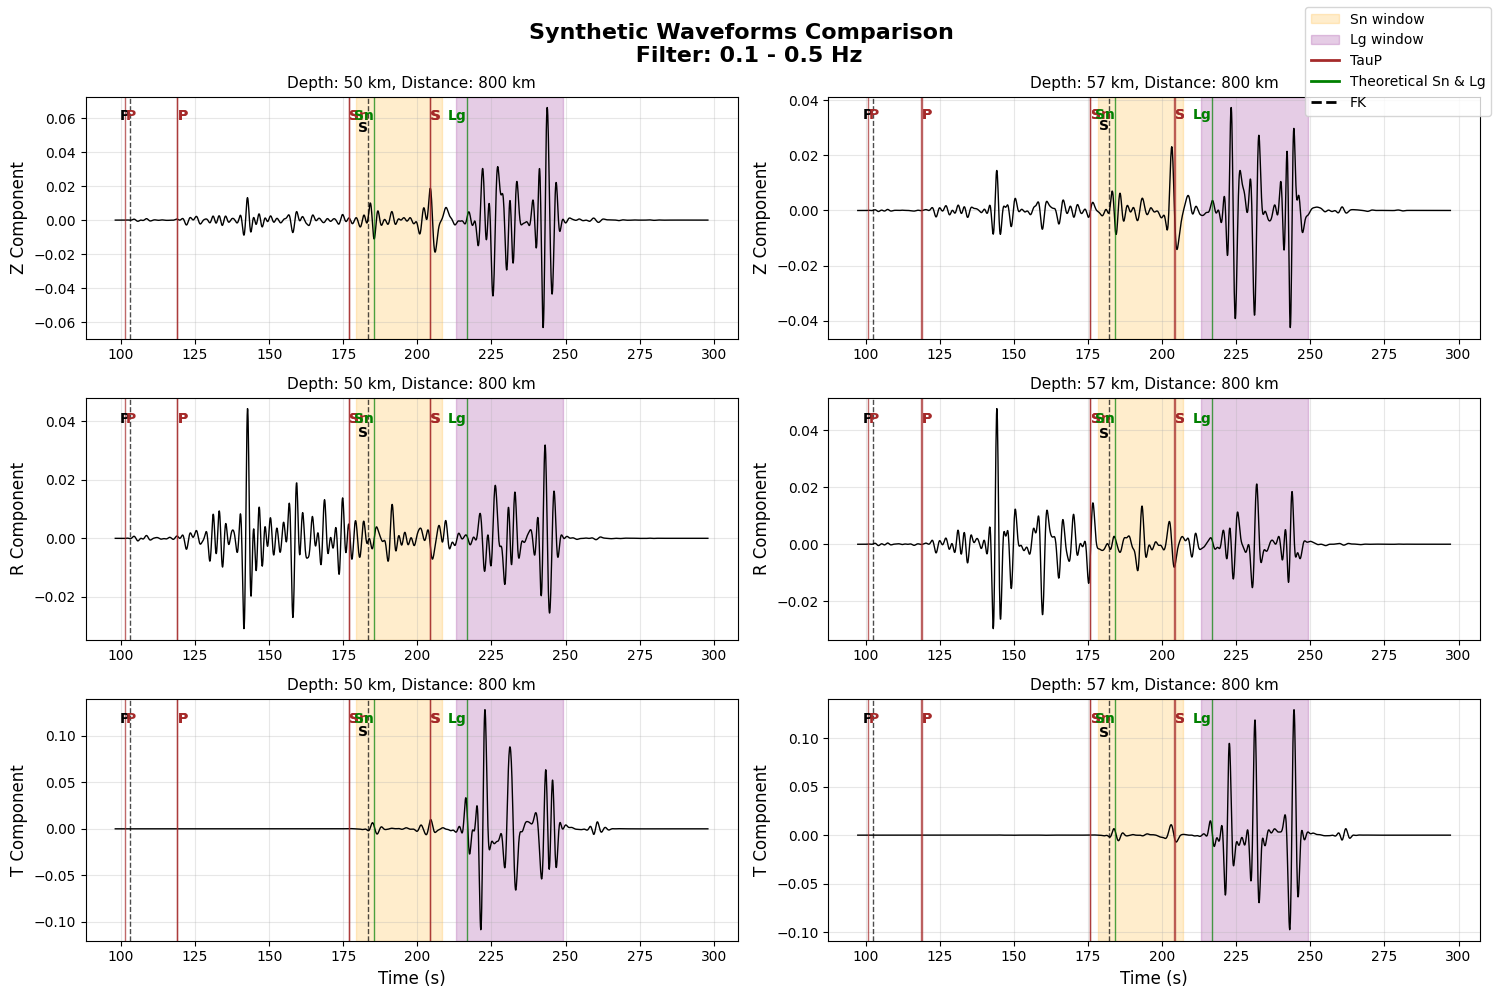

In [13]:
# MODIFY parameters below
depth_index_1 = 1
receiver_index_1 = 0
depth_index_2 = 2
receiver_index_2 = 0
plot_FKArrivals = True
plot_TauP = True
phases = ["Sn", "S", "P"]
plot_SnLgArrivals = True

# Get the corresponding depth and distance values
depth_1 = parameters.source_depths[depth_index_1]
receiver_distance_1 = parameters.receiver_distances[receiver_index_1]
depth_2 = parameters.source_depths[depth_index_2]
receiver_distance_2 = parameters.receiver_distances[receiver_index_2]

# Get the streams and SnLg info for these combinations
stream_1 = sync_results[depth_index_1][receiver_index_1]
stream_2 = sync_results[depth_index_2][receiver_index_2]
result_1 = find_result(depth_1, receiver_distance_1, results)
result_2 = find_result(depth_2, receiver_distance_2, results)

# Run TauP
model = TauPyModel(model='Tibetan_model.npz')
deg_1 = kilometers2degrees(receiver_distance_1)
arrivals_1 = model.get_travel_times(source_depth_in_km=depth_1, distance_in_degree=deg_1)
deg_2 = kilometers2degrees(receiver_distance_2)
arrivals_2 = model.get_travel_times(source_depth_in_km=depth_2, distance_in_degree=deg_2)
# print(f'Arrivals for source at {depth_1} km: \n', arrivals_1)
# print(f'Arrivals for source at {depth_2} km: \n', arrivals_2)
# arrivalsPlot_1 = model.get_ray_paths(source_depth_in_km=depth_1, distance_in_degree=deg_1, phase_list=["Sn"])
# arrivalsPlot_1.plot_rays(plot_type='cartesian', phase_list=["Sn"],
#                    plot_all=False, legend=True)
# arrivalsPlot_2 = model.get_ray_paths(source_depth_in_km=depth_2, distance_in_degree=deg_2, phase_list=["S"])
# arrivalsPlot_2.plot_rays(plot_type='cartesian', phase_list=["S"],
#                    plot_all=False, legend=True)

# Create the plot
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle(f'Synthetic Waveforms Comparison \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz', fontsize=16, fontweight='bold')

# Component names and colors
components = ['Z', 'R', 'T']
colors = ['black', 'black', 'black']

for i, (component, color) in enumerate(zip(components, colors)):
    # Left column - Synthetic 1
    ax_left = axes[i, 0]
    trace_1 = process_component(stream_1[i], parameters)
    time_1 = np.arange(len(trace_1)) * trace_1.stats.delta + trace_1.stats.sac.b
    ax_left.plot(time_1, trace_1.data, color=color, linewidth=1)
    ax_left.set_ylabel(f'{component} Component', fontsize=12)
    ax_left.grid(True, alpha=0.3)
    ax_left.set_title(f'Depth: {depth_1} km, Distance: {receiver_distance_1} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_1:
        sn_window, lg_window = result_1[4], result_1[5]
        if sn_window:
            ax_left.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2, label='Sn window' if i == 0 else "")
        if lg_window:
            ax_left.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2, label='Lg window' if i == 0 else "")
    # Add P and S arrivals
    if plot_FKArrivals:
        if hasattr(trace_1.stats, 'sac'):
            p_time = getattr(trace_1.stats.sac, 't1', None)
            s_time = getattr(trace_1.stats.sac, 't2', None)
            if p_time is not None and p_time != -12345:
                ax_left.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_left.text(p_time, ax_left.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                            horizontalalignment='right', verticalalignment='top')
            if s_time is not None and s_time != -12345:
                ax_left.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_left.text(s_time, ax_left.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
    # Add TauP arrivals
    if plot_TauP:
        for arrival_1 in arrivals_1:
            if arrival_1.name in phases:
                if arrival_1.time < lg_window[1] + 20:
                    # Set color based on arrival name
                    ax_left.axvline(x=arrival_1.time, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                    y_pos = ax_left.get_ylim()[1] * 0.9
                    ax_left.text(arrival_1.time + 0.2, y_pos, arrival_1.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals:
        if result_1:
            tsn, tlg = result_1[8], result_1[9]
            ax_left.axvline(x=tsn, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_left.text(tsn, ax_left.get_ylim()[1]*0.9, 'Sn', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
            ax_left.axvline(x=tlg, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_left.text(tlg, ax_left.get_ylim()[1]*0.9, 'Lg', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')

    # Right column - Synthetic 2
    ax_right = axes[i, 1]
    trace_2 = process_component(stream_2[i], parameters)
    time_2 = np.arange(len(trace_2)) * trace_2.stats.delta + trace_2.stats.sac.b
    ax_right.plot(time_2, trace_2.data, color=color, linewidth=1)
    ax_right.set_ylabel(f'{component} Component', fontsize=12)
    ax_right.grid(True, alpha=0.3)
    ax_right.set_title(f'Depth: {depth_2} km, Distance: {receiver_distance_2} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_2:
        sn_window, lg_window = result_2[4], result_2[5]
        if sn_window:
            ax_right.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2)
        if lg_window:
            ax_right.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2)
    # Add P and S arrivals
    if plot_FKArrivals:
        if hasattr(trace_2.stats, 'sac'):
            p_time = getattr(trace_2.stats.sac, 't1', None)
            s_time = getattr(trace_2.stats.sac, 't2', None)
            if p_time is not None and p_time != -12345:
                ax_right.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_right.text(p_time, ax_right.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                            horizontalalignment='right', verticalalignment='top')
            if s_time is not None and s_time != -12345:
                ax_right.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_right.text(s_time, ax_right.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
    # Add TauP arrivals
    if plot_TauP:
        for arrival_2 in arrivals_2:
            if arrival_2.name in phases:
                if arrival_2.time < lg_window[1] + 20:
                    # Set color based on arrival name
                    ax_right.axvline(x=arrival_2.time, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                    y_pos = ax_right.get_ylim()[1] * 0.9
                    ax_right.text(arrival_2.time + 0.2, y_pos, arrival_2.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals:
        if result_2:
            tsn, tlg = result_2[8], result_2[9]
            ax_right.axvline(x=tsn, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_right.text(tsn, ax_right.get_ylim()[1]*0.9, 'Sn', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
            ax_right.axvline(x=tlg, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_right.text(tlg, ax_right.get_ylim()[1]*0.9, 'Lg', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')

# Set x-axis labels for the bottom subplots
axes[-1, 0].set_xlabel('Time (s)', fontsize=12)
axes[-1, 1].set_xlabel('Time (s)', fontsize=12)

# Add legend
handles, labels = [], []
for ax in [axes[0, 0], axes[0, 1]]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
custom_lines = [
    Line2D([0], [0], color='brown', lw=2, label='TauP') if plot_TauP else None,
    Line2D([0], [0], color='green', lw=2, label='Theoretical Sn & Lg') if plot_SnLgArrivals else None,
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='FK') if plot_FKArrivals else None,
]
custom_lines = [line for line in custom_lines if line is not None]
if handles:
    fig.legend(handles + custom_lines, labels + [line.get_label() for line in custom_lines], loc='upper right')
else:
    fig.legend(custom_lines, [line.get_label() for line in custom_lines], loc='upper right')

print('Synthetic 1 ln(Sn/Lg):', result_1[2]) # index 2 is raw, 3 is cor
print('Synthetic 2 ln(Sn/Lg):', result_2[2])

plt.tight_layout()
plt.show()


## Plot synthetics versus depth

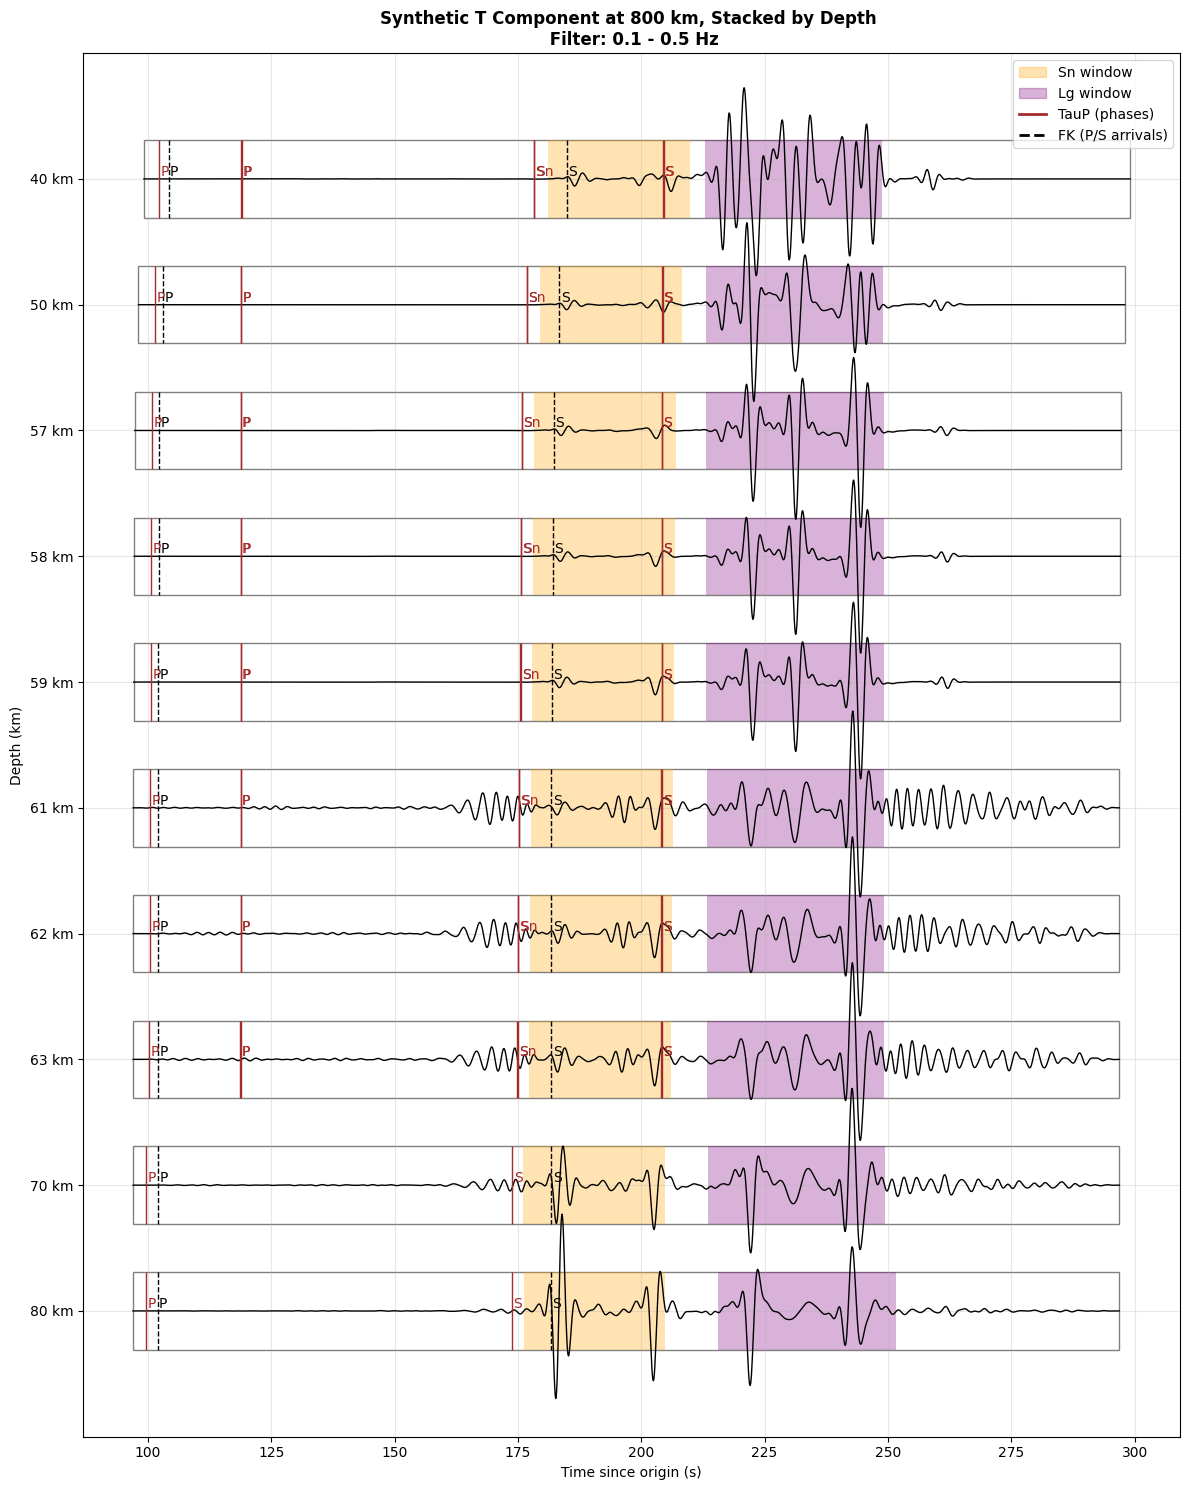

In [14]:
# MODIFY to choose receiver distance
receiver_index = 0
plot_FKArrivals2 = True
plot_TauP2 = True
phases = ["Sn", "S", "P"]
plot_SnLgArrivals2 = False

n_depths = len(sync_results)
trace_height = 1.3  # vertical space per trace
box_height = 0.8    # height of the box around each trace
fig, ax = plt.subplots(figsize=(12, 1.5 * n_depths))

for depth_idx in range(n_depths):
    # print(f"Depth: {parameters.source_depths[depth_idx]} km, Receiver: {parameters.receiver_distances[receiver_index]} km")
    stream = sync_results[depth_idx][receiver_index]
    tr = process_component(stream[-1], parameters)
    t = np.arange(tr.stats.npts) * tr.stats.delta + tr.stats.sac.b
    data = tr.data / np.max(np.abs(tr.data))
    y_base = depth_idx * trace_height
    y_bottom = y_base - box_height/2

    # Draw the main rectangle for this trace
    rect = Rectangle(
        (t[0], y_bottom),
        t[-1] - t[0],
        box_height,
        linewidth=1, edgecolor='gray', facecolor='none', zorder=0
    )
    ax.add_patch(rect)

    # Highlight Sn/Lg windows as filled rectangles within the box
    result = find_result(parameters.source_depths[depth_idx], parameters.receiver_distances[receiver_index], results)
    if result:
        sn_window, lg_window = result[4], result[5]
        if sn_window:
            sn_rect = Rectangle(
                (sn_window[0], y_bottom),
                sn_window[1] - sn_window[0],
                box_height,
                linewidth=0, facecolor='orange', alpha=0.3, zorder=1,
            )
            ax.add_patch(sn_rect)
        if lg_window:
            lg_rect = Rectangle(
                (lg_window[0], y_bottom),
                lg_window[1] - lg_window[0],
                box_height,
                linewidth=0, facecolor='purple', alpha=0.3, zorder=1,
            )
            ax.add_patch(lg_rect)

    # Plot the trace, vertically offset
    ax.plot(t, data + y_base, color='black', linewidth=1, zorder=2)

    # Add FK arrivals
    if plot_FKArrivals2:
        if hasattr(tr.stats, 'sac'):
            b = tr.stats.sac.b if hasattr(tr.stats.sac, 'b') else 0.0
            t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
            t2 = tr.stats.sac.t2 if hasattr(tr.stats.sac, 't2') else None
            if t1 is not None and t1 != -12345:
                ax.vlines(t1, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
                ax.text(t1 + .3, y_base, 'P', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
            if t2 is not None and t2 != -12345:
                ax.vlines(t2, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
                ax.text(t2 + .3, y_base, 'S', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals2:
        if result:
            tsn, tlg = result[8], result[9]
            ax.vlines(tsn, y_bottom, y_bottom + box_height, color='green', linestyle='-', linewidth=1, zorder=3)
            ax.vlines(tlg, y_bottom, y_bottom + box_height, color='green', linestyle='-', linewidth=1, zorder=3)
            ax.text(tsn + .3, y_base, 'Sn', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
            ax.text(tlg + .3, y_base, 'Lg', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
    # Add TauP arrivals
    deg_all = kilometers2degrees(parameters.receiver_distances[receiver_index])
    arrivals_per_depth = model.get_travel_times(source_depth_in_km=parameters.source_depths[depth_idx], distance_in_degree=deg_all)
    # print(f'Arrivals for source at {parameters.source_depths[depth_idx]} km: \n', arrivals_per_depth)
    if plot_TauP2:
        for arrival in arrivals_per_depth:
            if arrival.name in phases:
                if arrival.time < lg_window[1] + 20:
                    ax.vlines(arrival.time, y_bottom, y_bottom + box_height, color='brown', linestyle='-', linewidth=1, zorder=3)
                    ax.text(arrival.time + .3, y_base, arrival.name, color='brown', fontsize=10, ha='left', va='bottom', zorder=4)
    
    # Verify P arrival time
    # for depth_idx in range(n_depths):
    #     stream = sync_results[depth_idx][receiver_index]
    #     tr = stream[-1]
    #     t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
    #     print(f"Depth {parameters.source_depths[depth_idx]} km: P arrival (t1) = {t1}")

# Set y-limits to fit all traces with a little padding
ax.set_ylim(-trace_height, n_depths * trace_height)
ax.set_yticks([i * trace_height for i in range(n_depths)])
ax.set_yticklabels([f"{d} km" for d in parameters.source_depths])
ax.invert_yaxis()  # Depth increases downward

ax.set_xlabel("Time since origin (s)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Synthetic T Component at {parameters.receiver_distances[receiver_index]} km, Stacked by Depth \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz", fontweight='bold')
ax.grid(True, alpha=0.3)

# --- Add custom legend ---
custom_lines = [
    Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Sn window'),
    Patch(facecolor='purple', edgecolor='purple', alpha=0.3, label='Lg window'),
    Line2D([0], [0], color='brown', lw=2, label='TauP (phases)') if plot_TauP2 else None,
    Line2D([0], [0], color='green', lw=2, label='Theoretical Sn & Lg') if plot_SnLgArrivals2 else None,
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='FK (P/S arrivals)') if plot_FKArrivals2 else None,
]
custom_lines = [line for line in custom_lines if line is not None]
ax.legend(handles=custom_lines, loc='upper right')
plt.tight_layout()
plt.show()

# Plot results

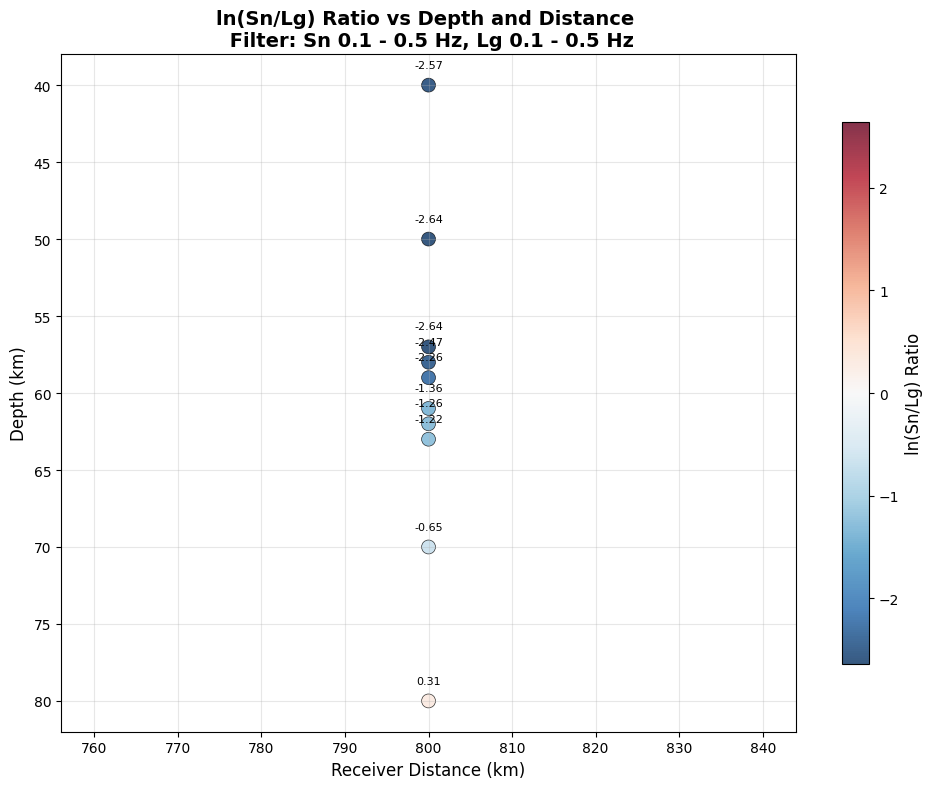

Total data points: 10
Valid ratios: 10
Missing ratios: 0


In [15]:
# Extract data for plotting
depths = []
receiver_distances = []
ratios = []
sn_amps = []
lg_amps = []

for result in results:
    depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg, tsn, tlg = result
    depths.append(depth)
    receiver_distances.append(receiver_distance)
    ratios.append(snlg_raw) # use raw or cor
    sn_amps.append(amp_sn)
    lg_amps.append(amp_lg)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Separate data points with valid ratios and None ratios
valid_indices = [i for i, ratio in enumerate(ratios) if ratio is not None]
none_indices = [i for i, ratio in enumerate(ratios) if ratio is None]

# Plot valid ratio points with color mapping
if valid_indices:
    valid_depths = [depths[i] for i in valid_indices]
    valid_distances = [receiver_distances[i] for i in valid_indices]
    valid_ratios = [ratios[i] for i in valid_indices]
    
    # Create scatter plot with color mapping
    scatter = ax.scatter(valid_distances, valid_depths, 
                        c=valid_ratios, 
                        cmap='RdBu_r',  # Red-Blue diverging colormap (red=high, blue=low)
                        s=100,  # Marker size
                        edgecolors='black',  # Black edges
                        linewidth=0.5,
                        alpha=0.8,
                        vmin=-max(abs(min(valid_ratios)), abs(max(valid_ratios))),  # Set symmetric range
                        vmax=max(abs(min(valid_ratios)), abs(max(valid_ratios))))   # Set symmetric range 
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('ln(Sn/Lg) Ratio', fontsize=12)
    # Label each valid point with its ratio value
    for x, y, ratio in zip(valid_distances, valid_depths, valid_ratios):
        ax.text(x, y - 1, f"{ratio:.2f}", fontsize=8, ha='center', va='bottom', color='black')

# Plot None ratio points in gray
if none_indices:
    none_depths = [depths[i] for i in none_indices]
    none_distances = [receiver_distances[i] for i in none_indices]
    
    ax.scatter(none_distances, none_depths, 
              c='gray', 
              s=100, 
              edgecolors='black',
              linewidth=0.5,
              alpha=0.8,
              label='No ratio available')

# Customize the plot
ax.set_xlabel('Receiver Distance (km)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_title(f'ln(Sn/Lg) Ratio vs Depth and Distance \n Filter: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total data points: {len(results)}")
print(f"Valid ratios: {len(valid_indices)}")
print(f"Missing ratios: {len(none_indices)}")

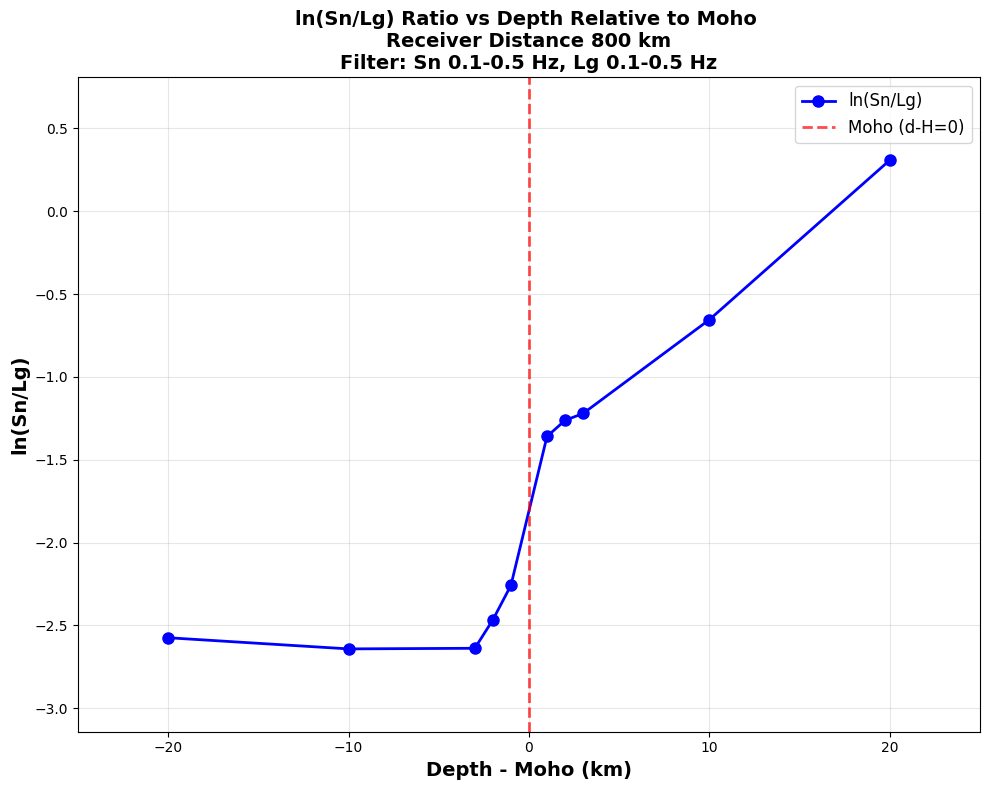

In [16]:
# Extract data for plotting
depths = []
receiver_distances = []
ratios = []
sn_amps = []
lg_amps = []

for result in results:
    depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg, tsn, tlg = result
    depths.append(depth)
    receiver_distances.append(receiver_distance)
    ratios.append(snlg_raw)  # use raw or cor
    sn_amps.append(amp_sn)
    lg_amps.append(amp_lg)

# Set Moho depth
moho_depth = 60.0  # Adjust this to your model's Moho depth

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Separate data points with valid ratios and None ratios
valid_indices = [i for i, ratio in enumerate(ratios) if ratio is not None]
none_indices = [i for i, ratio in enumerate(ratios) if ratio is None]

# Plot valid ratio points
if valid_indices:
    valid_depths = [depths[i] for i in valid_indices]
    valid_ratios = [ratios[i] for i in valid_indices]
    
    # Calculate (depth - Moho depth)
    depth_minus_moho = np.array(valid_depths) - moho_depth
    
    # Plot the data
    ax.plot(depth_minus_moho, valid_ratios, 'bo-', linewidth=2, markersize=8, label='ln(Sn/Lg)')
    
    # # Add annotations for each point
    # for d_moho, ratio, depth in zip(depth_minus_moho, valid_ratios, valid_depths):
    #     ax.annotate(f'{depth}km', (d_moho, ratio), 
    #                xytext=(5, 5), textcoords='offset points', 
    #                fontsize=10, ha='left', va='bottom')

# Add reference lines
ax.axvline(x=0, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Moho (d-H=0)')

# Customize the plot
ax.set_xlabel('Depth - Moho (km)', fontsize=14, fontweight='bold')
ax.set_ylabel('ln(Sn/Lg)', fontsize=14, fontweight='bold')
ax.set_title(f'ln(Sn/Lg) Ratio vs Depth Relative to Moho \nReceiver Distance {parameters.receiver_distances[receiver_index]} km\nFilter: Sn {parameters.Sn_freqmin}-{parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin}-{parameters.Lg_freqmax} Hz', 
             fontsize=14, fontweight='bold')

# Add grid
ax.grid(True, alpha=0.3)

# Add legend
ax.legend(fontsize=12)

# Set axis limits with some padding
if valid_indices:
    x_padding = 5
    y_padding = 0.5
    ax.set_xlim(min(depth_minus_moho) - x_padding, max(depth_minus_moho) + x_padding)
    ax.set_ylim(min(valid_ratios) - y_padding, max(valid_ratios) + y_padding)

plt.tight_layout()
plt.show()